In [224]:
import pandas as pd
import pickle
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
import seaborn as sns
import phik

In [225]:
df = pd.read_csv("./dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93312 entries, 0 to 93311
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       93312 non-null  float64
 1   Occupation                93312 non-null  int64  
 2   Annual_Income             93312 non-null  float64
 3   Monthly_Inhand_Salary     93312 non-null  float64
 4   Num_Bank_Accounts         93312 non-null  float64
 5   Num_Credit_Card           93312 non-null  float64
 6   Interest_Rate             93312 non-null  float64
 7   Num_of_Loan               93312 non-null  int64  
 8   Delay_from_due_date       93312 non-null  float64
 9   Num_of_Delayed_Payment    93312 non-null  float64
 10  Changed_Credit_Limit      93312 non-null  float64
 11  Num_Credit_Inquiries      93312 non-null  float64
 12  Credit_Mix                93312 non-null  int64  
 13  Outstanding_Debt          93312 non-null  float64
 14  Credit

In [226]:
def cross_val_metrics(clf, X, y, cv=5):
    accuracy = []
    f1 = []
    precision = []
    recall = []
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=36)
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy.append(metrics.accuracy_score(y_test, y_pred))
        precision.append(metrics.precision_score(y_test, y_pred, average=None))
        recall.append(metrics.recall_score(y_test, y_pred, average=None))
        f1.append(metrics.f1_score(y_test, y_pred, average=None))
    print("accuracy", np.mean(accuracy))
    print("precision", np.mean(precision, axis=0))
    print("recall",np.mean(recall, axis=0))
    print("f1",np.mean(f1, axis=0))

In [227]:
corr = df.phik_matrix(df.columns)
corr_target = corr["Credit_Score"].drop("Credit_Score", axis=0)
corr_target.describe()

count    30.000000
mean      0.298092
std       0.163013
min       0.029144
25%       0.146144
50%       0.253588
75%       0.435142
max       0.646078
Name: Credit_Score, dtype: float64

In [228]:
#relevant_features = corr_target[corr_target > corr_target.quantile(1/3)]
relevant_features = corr_target
relevant_features.sort_values(inplace=True)
relevant_features = relevant_features.tail(15)
relevant_features

Debt Consolidation Loan    0.257145
Changed_Credit_Limit       0.272360
Monthly_Inhand_Salary      0.273856
Annual_Income              0.299714
Credit_Mix                 0.408959
Num_of_Loan                0.418945
Credit_History_Age         0.431740
Num_of_Delayed_Payment     0.436276
Num_Bank_Accounts          0.465395
Delay_from_due_date        0.479387
Num_Credit_Inquiries       0.480212
Num_Credit_Card            0.496723
Outstanding_Debt           0.527545
Interest_Rate              0.556082
Payment_of_Min_Amount      0.646078
Name: Credit_Score, dtype: float64

In [229]:
corr_features = df[relevant_features.index].phik_matrix(interval_cols=relevant_features.index)
corr_features.values[np.tril_indices_from(corr_features.values)] = np.nan

In [230]:
corr_features

,Debt Consolidation Loan,Changed_Credit_Limit,Monthly_Inhand_Salary,Annual_Income,Credit_Mix,Num_of_Loan,Credit_History_Age,Num_of_Delayed_Payment,Num_Bank_Accounts,Delay_from_due_date,Num_Credit_Inquiries,Num_Credit_Card,Outstanding_Debt,Interest_Rate,Payment_of_Min_Amount
Debt Consolidation Loan,NaN,0.149449,0.128885,0.131310,0.219646,0.353837,0.226245,0.170988,0.182530,0.191633,0.206178,0.161093,0.240005,0.207047,0.316733
Changed_Credit_Limit,NaN,NaN,0.226495,0.238280,0.502053,0.479954,0.495226,0.395257,0.403482,0.381203,0.437550,0.343529,0.581483,0.427966,0.504855
Monthly_Inhand_Salary,NaN,NaN,NaN,0.992917,0.321616,0.362126,0.346829,0.315354,0.342872,0.301515,0.353742,0.283365,0.383858,0.367314,0.340837
Annual_Income,NaN,NaN,NaN,NaN,0.337774,0.380004,0.368637,0.320544,0.354859,0.316950,0.378219,0.301835,0.412627,0.389531,0.349651
Credit_Mix,NaN,NaN,NaN,NaN,NaN,0.582270,0.551585,0.655158,0.647745,0.609559,0.560352,0.526649,0.625751,0.657552,0.482326
Num_of_Loan,NaN,NaN,NaN,NaN,NaN,NaN,0.620356,0.501870,0.522753,0.522449,0.585636,0.481810,0.666117,0.583524,0.522342
Credit_History_Age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.486877,0.515012,0.497098,0.603831,0.467439,0.675280,0.578242,0.565184
Num_of_Delayed_Payment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600611,0.551427,0.496093,0.468827,0.527883,0.570070,0.545333
Num_Bank_Accounts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.588855,0.542030,0.508661,0.564061,0.601128,0.554648
Delay_from_due_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.529880,0.517202,0.571906,0.579961,0.498264


In [231]:
corr_features.unstack().describe()

count    105.000000
mean       0.454258
std        0.152323
min        0.128885
25%        0.346829
50%        0.496093
75%        0.565184
max        0.992917
dtype: float64

<AxesSubplot:>

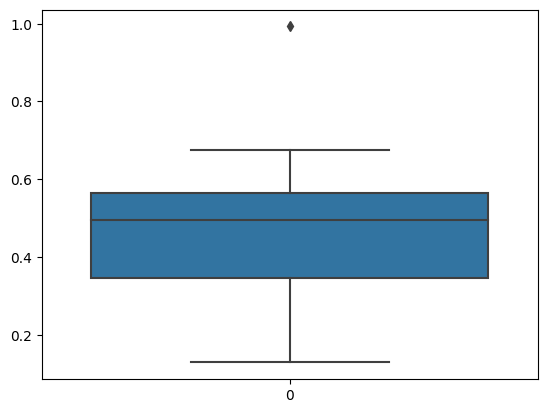

In [232]:
sns.boxplot(corr_features.unstack().dropna())

In [233]:
corr_features = corr_features.unstack().sort_values(ascending=False).dropna()

In [234]:
corr_arr = []
thresold = 0.75

for cols, value in zip(corr_features.index, corr_features):
    col1, col2 = cols
    if value < thresold:
        break
    print(col1, col2, value)
    if col1 == col2 or col1 in corr_arr or col2 in corr_arr:
        continue
    if relevant_features[col1] < relevant_features[col2]:
        corr_arr.append(col1)
    else:
        corr_arr.append(col2)

Annual_Income Monthly_Inhand_Salary 0.9929171527060506


In [235]:
relevant_features.drop(corr_arr, axis=0, inplace=True)

In [236]:
relevant_features

Debt Consolidation Loan    0.257145
Changed_Credit_Limit       0.272360
Annual_Income              0.299714
Credit_Mix                 0.408959
Num_of_Loan                0.418945
Credit_History_Age         0.431740
Num_of_Delayed_Payment     0.436276
Num_Bank_Accounts          0.465395
Delay_from_due_date        0.479387
Num_Credit_Inquiries       0.480212
Num_Credit_Card            0.496723
Outstanding_Debt           0.527545
Interest_Rate              0.556082
Payment_of_Min_Amount      0.646078
Name: Credit_Score, dtype: float64

In [237]:
corr_arr

['Monthly_Inhand_Salary']

In [238]:
labels = ['Poor', 'Standard', 'Good']

In [239]:
X = df[relevant_features.index]
y = df['Credit_Score']
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=36)

print(X_train.shape, y_train.shape)

(74649, 14) (74649,)


In [240]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y_test, y_pred, target_names=labels))

               Predict Poor  Predict Standard  Predict Good
True Poor              4216              1003            36
True Standard          1182              8133           765
True Good                19               861          2448
              precision    recall  f1-score   support

        Poor       0.78      0.80      0.79      5255
    Standard       0.81      0.81      0.81     10080
        Good       0.75      0.74      0.74      3328

    accuracy                           0.79     18663
   macro avg       0.78      0.78      0.78     18663
weighted avg       0.79      0.79      0.79     18663



In [241]:
cross_val_metrics(clf, X, y, cv=5)

accuracy 0.8030157377450318
precision [0.79028448 0.81997605 0.77133569]
recall [0.81047349 0.81909997 0.74251699]
f1 [0.80023793 0.81952156 0.75660004]
